# Split one 3x7 surface code into two d=3 surface codes

This notebooks simulates the following experiment:
* A 3x7 rotated surface code patch is initialized in either $\ket{0}$, $\ket{1}$, $\ket{+}$, or $\ket{-}$,
* there is one syndrome extraction cycle performed for the whole patch,
* the 3x7 patch is split into two d=3 rotated surface code patches and their respective logical operators are updated correspondingly (both the pauli string as well as the pauli frame),
* one syndrome extraction cycle is performed on the two new patches respectively,
* the two patches are measured in different bases to allow for logical quantum state tomography.

Note that in this notebook, the coordinates and orientation of the patches are chosen such that the logical X operator of the initial patch has length 7 while the logical Z operator has length 3. After the split, the 7 qubit long X operator is split into two X operators of length 3. One of the new logical Z operators is equivalent to the initial logical Z operator. The logical Z operator of the other patch is chosen to lie parallel to the split boundary and directly next to it.

In [1]:
import qeclib
from qeclib import Stabilizer, RotSurfCode, PauliOp, SquareLattice, QECPlot
import numpy as np
import pprint
import stim
import copy

In [2]:
Q1 = RotSurfCode(
    id="Q1",
    dx=7,
    dz=3,
)
Q1.log_z.data_qubits = [
    (2, 0, 0),
    (2, 1, 0),
    (2, 2, 0),
]  # In the current implementation, the operators need to lie at the split boundary

circ = SquareLattice(
    name="", rows=Q1.dz + 2, cols=Q1.dx + 2
)  # Just for fun, make the lattice a little bit bigger than needed
circ.add_logical_qubit(Q1)
circ.init("Q1", "1")  # CHANGE THE INITIAL STATE HERE

Plot the lattice with the one logical patch:

In [3]:
qecplot = QECPlot(circ)
qecplot.plot_logical_qubit("Q1")
qecplot.show()

Now add the split operation:

In [4]:
circ.split("Q1", [(3,0,0), (3,1,0), (3,2,0)], ["Q2", "Q3"])

Now after the split, plot again the current configuration of the lattice. Now one can see that there are two logical qubit patches with two logical operators each:

In [5]:
qecplot = QECPlot(circ)
qecplot.plot_logical_qubit("Q2")
qecplot.plot_logical_qubit("Q3")
qecplot.show()

Add syndrome extraction circuits. Note that the corresponding function returns a list with uuids. These uuids can be used to access exactly these measurements after the experiment has been performed.

In [6]:
uuids_Q2 = circ.add_par_def_syndrome_extraction_circuit("Q2")
uuids_Q3 = circ.add_par_def_syndrome_extraction_circuit("Q3")

Perform logical quantum state tomography:

In [7]:
bases = ["I", "X", "Z"]
res_dict = qeclib.circ_log_QST_results(circ, num_shots=3000, bases=bases)
for basis, exp_val in res_dict.items():
    print(f"<{basis}> = {np.round(exp_val, 3)}")

<II> = 0.0
<IX> = 0.509
<IZ> = 1.0
<XI> = 0.494
<XX> = 0.504
<XZ> = 0.502
<ZI> = 1.0
<ZX> = 0.505
<ZZ> = 0.0


Plot the expectation values in a 3D bar chart:

C:\Users\jonat\AppData\Local\Temp\ipykernel_3260\769122824.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



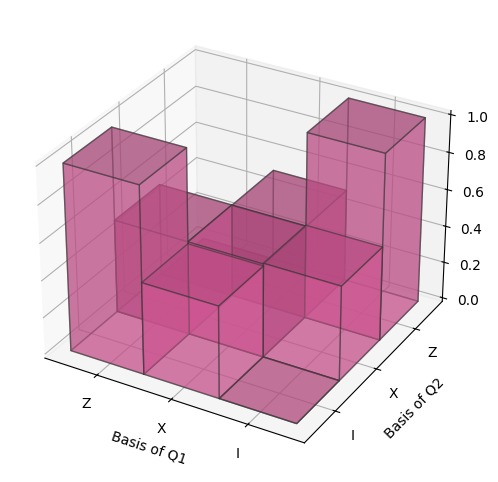

In [8]:
fig = qeclib.plot_log_QST_results(res_dict)
fig.show()

#### Expected results
The quantum state tomography plot above hopefully shows exactly what we expect. What we expect is the following:

Let's denote the initial state of the 3x7 patch with $\ket{Q1}$. We denote the measurement result of an operator on a $+1$ eigenstate with $0$ and of a $-1$ eigenstate with $1$. Then we expect:

If $\ket{Q1} = \ket{+}$:
* $\langle X_{L1}X_{L2} \rangle = 0$ because $X_{L1} \cdot X_{L2} = X_L$ and we were in the $+1$ eigenstate of $X_L$ initially
* $\langle Z_{L1}Z_{L2} \rangle = 0$ holds always because the two operators are equivalent
* $\langle I_{L1}I_{L2} \rangle = 0$ (per definition, nothing is measured)
* All other expectation values are random (0.5)

If $\ket{Q1} = \ket{-}$:
* $\langle X_{L1}X_{L2} \rangle = 1$ because $X_{L1} \cdot X_{L2} = X_L$ and we were in the $-1$ eigenstate of $X_L$ initially
* $\langle Z_{L1}Z_{L2} \rangle = 0$ holds always because the two operators are equivalent
* $\langle I_{L1}I_{L2} \rangle = 0$
* All other expectation values are random (0.5)

If $\ket{Q1} = \ket{0}$:
* $\langle I_{L1}Z_{L2} \rangle = \langle Z_{L1}I_{L2} \rangle = \langle Z_{L1}Z_{L2} \rangle = \langle I_{L1}I_{L2} \rangle = 0$
* All other expectation values are random (0.5)

If $\ket{Q1} = \ket{1}$:
* $\langle I_{L1}Z_{L2} \rangle = \langle Z_{L1}I_{L2} \rangle = 1$ since we are in the $-1$ eigenstate of $Z_L$, both $Z_{L1}$ and $Z_{L2}$ are equivalent to $Z_L$ and we measure only one of them
* $\langle I_{L1}I_{L2} \rangle = \langle Z_{L1}Z_{L2} \rangle = 0$ holds always because the two operators are equivalent
* All other expectation values are random (0.5)

# Manual measurement in the end
For debugging and for understanding how the above code works, it might be useful to not use the `circ_log_QST_results` function but instead measure in just a single basis and analyze the respective simulation results. Essentially, `circ_log_QST_results` performs different experiments with different circuits where the circuits differ in the basis in which the logical qubits are measured in the end. This might obfuscate the underlying logic of the code, so here is the code without the logical QST wrapper:

In [9]:
mmt_basis = "ZZ"  # CHANGE THE MEASUREMENT BASIS HERE

circ_manual_meas = copy.deepcopy(circ)
if mmt_basis[0] == "X":
    m_id_Q2 = circ_manual_meas.m_log_x("Q2")
elif mmt_basis[0] == "Z":
    m_id_Q2 = circ_manual_meas.m_log_z("Q2")
if mmt_basis[1] == "X":
    m_id_Q3 = circ_manual_meas.m_log_x("Q3")
elif mmt_basis[1] == "Z":
    m_id_Q3 = circ_manual_meas.m_log_z("Q3")

stim_circ = stim.Circuit(circ_manual_meas.convert_to_stim())

It might be helpful to have a look at the stim circuit to understand what the experiment is that is performed here:

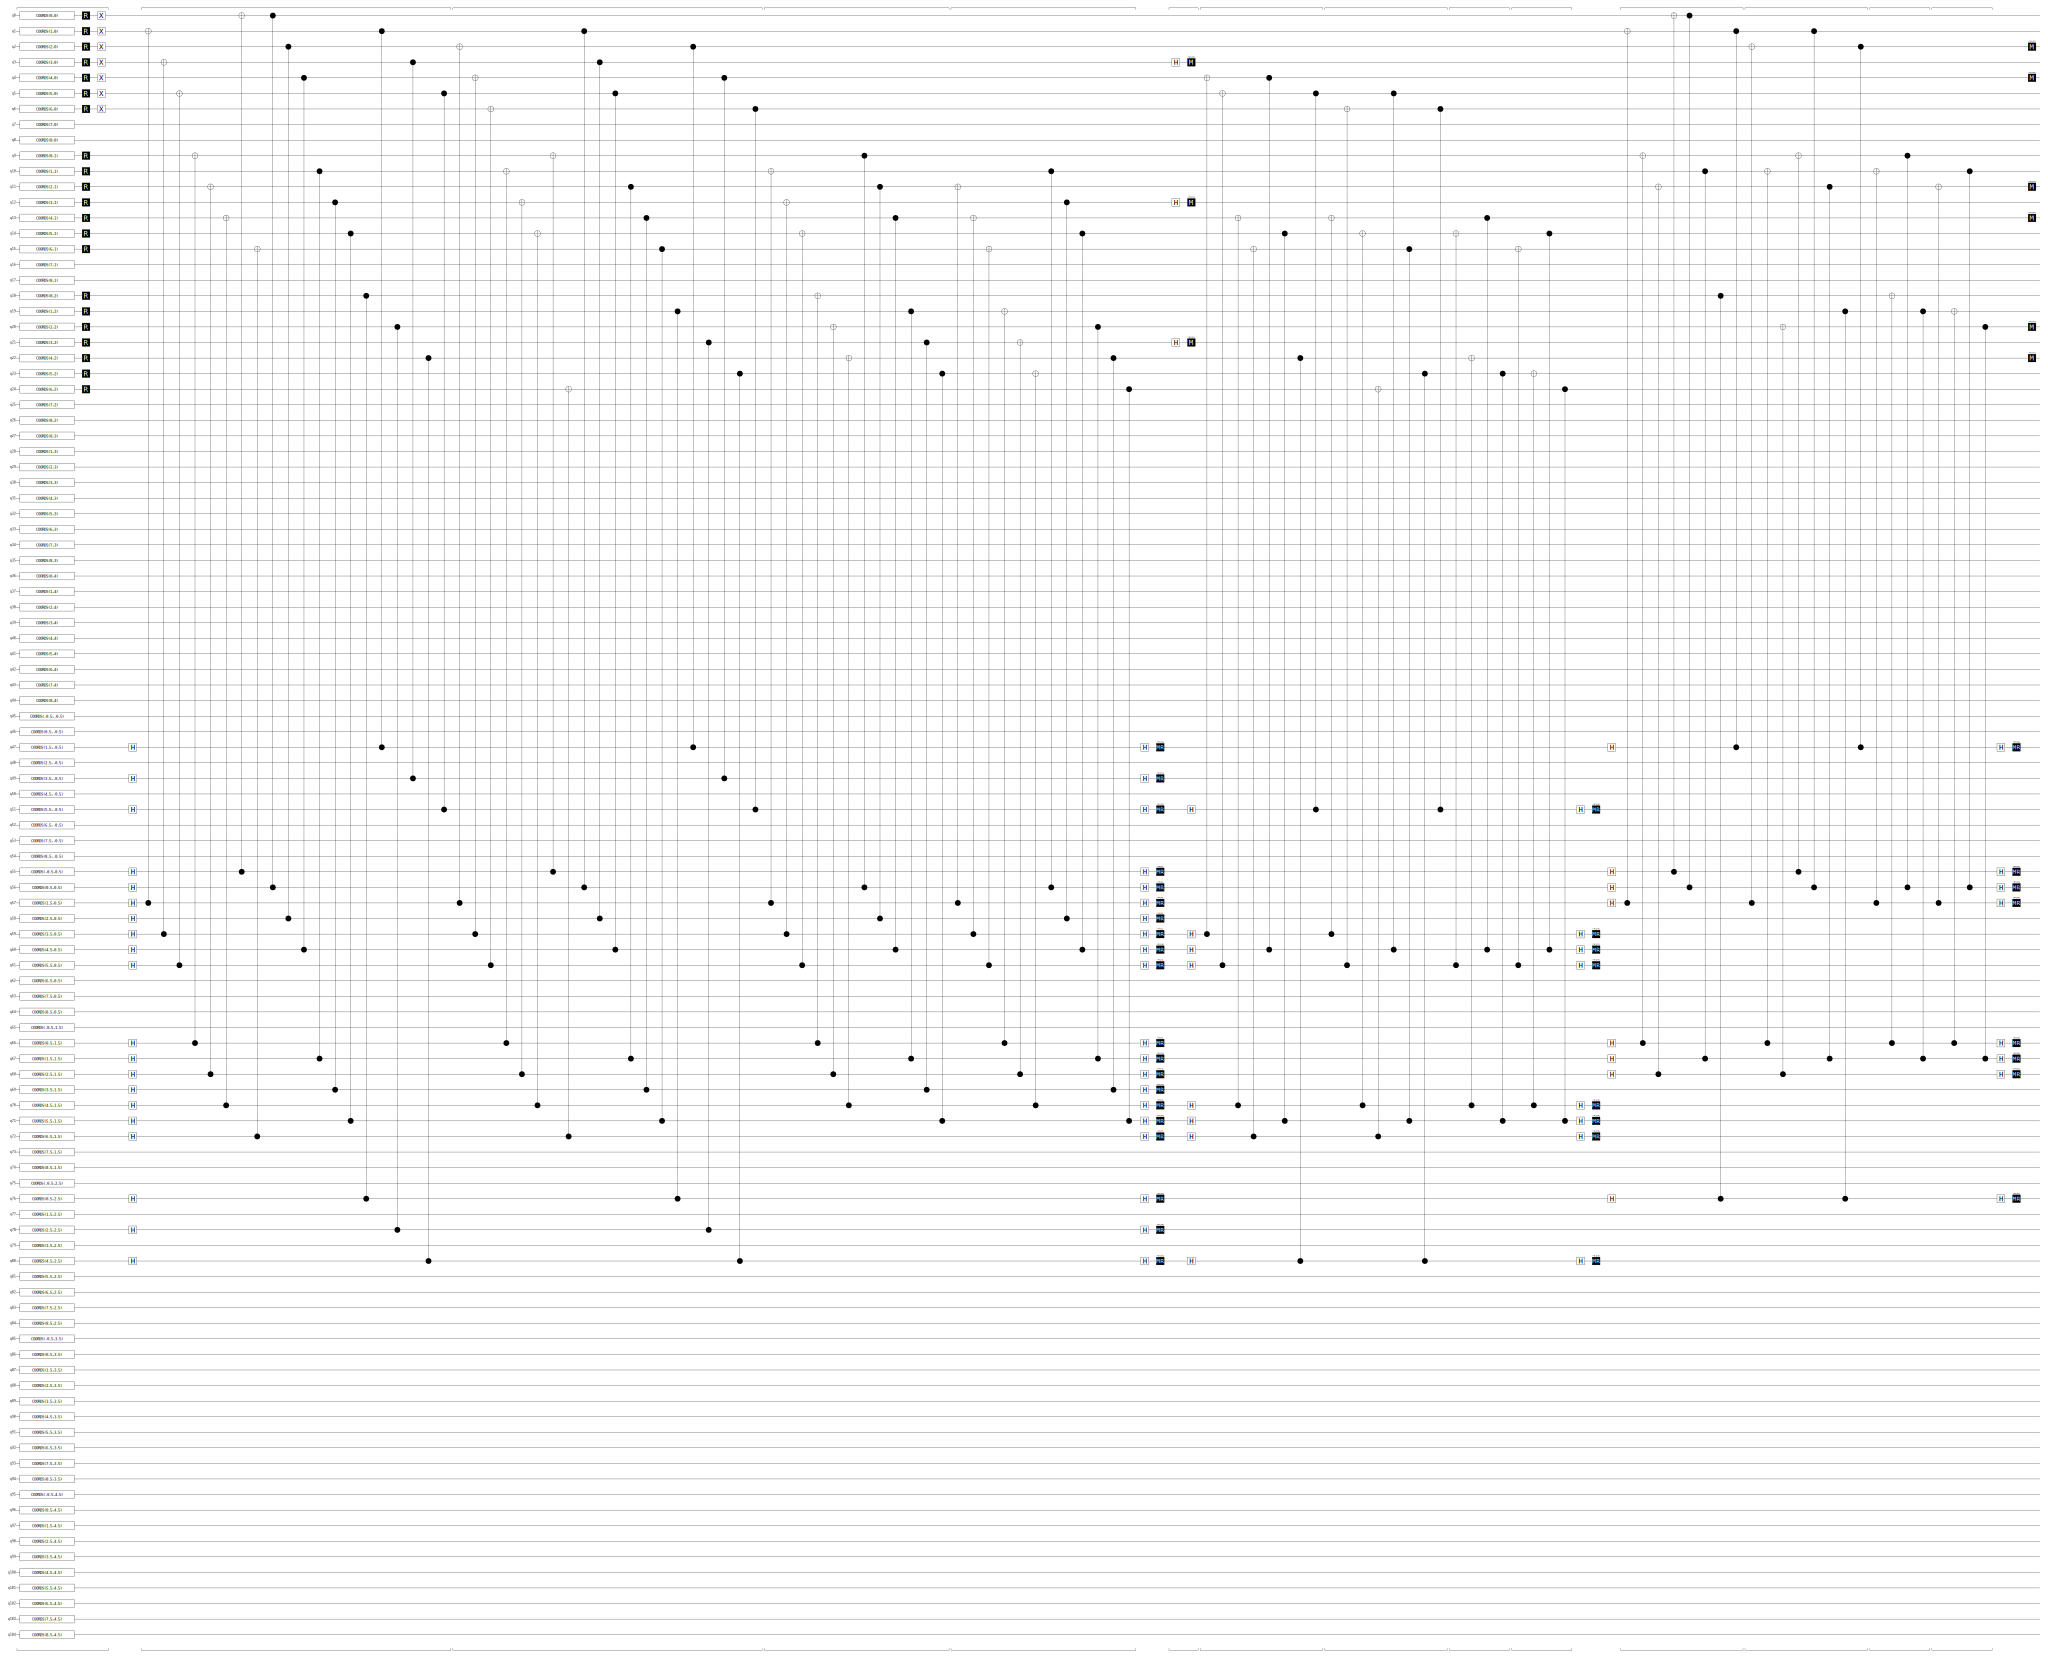

In [10]:
stim_circ.diagram(type="timeline-svg")

Perform the simulation and calculate the expectation value:

In [11]:
num_shots = 5
res = stim_circ.compile_sampler().sample(num_shots)
summed_res = 0
for r in res:
    print(circ_manual_meas.dict_m_uuids_to_res(r)[m_id_Q3])
    mmt_res = 0
    if mmt_basis[0] != "I":
        mmt_res += circ_manual_meas.get_log_dqb_readout(r, m_id_Q2, "Q2")
    if mmt_basis[1] != "I":
        mmt_res += circ_manual_meas.get_log_dqb_readout(r, m_id_Q3, "Q3")
    summed_res += mmt_res % 2
summed_res /= num_shots
print(f"<{mmt_basis}> = {np.round(summed_res, 3)}")

[ True  True  True]
[False  True False]
[ True False False]
[False  True False]
[False False  True]
<ZZ> = 0.0
